## Predicting Sale Price of Bulldozers

In this notebook, we will go through an example machine learning project with the goal of predicting the sale price of bulldozers.

The follow approaches will be taken:
1) Problem Definition
2) Data
3) Evaluation
4) Features
5) Modelling
6) Experimentation

---
### 1. Problem Definition
In a statement:
> How well can we predict the future sale price of a bulldozer, given its characteristics and historical data.

### 2. Data
The original data came from the Kaggle Bluebook for Bulldozer Competition: https://www.kaggle.com/competitions/bluebook-for-bulldozers/data


### 3. Evaluation
The evaluation metric for this project is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project, check:
https://www.kaggle.com/competitions/bluebook-for-bulldozers/overview

### 4. Features
The data is split into three parts:
- Train.csv is the training set, which contains data through the end of 2011
- Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012
- Test.csv is the test set, it contains data from May 1, 2012 - November 2012

Information about each features of the data:
A data dictionary detailing all the features of the dataset is provided and can be found under the name "Data Dictionary.xlsx"

---
### Importation of Libraries

In [1]:
# EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.ensemble import RandomForestRegressor

# Model Evaluation
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

---
### Load Data
##### Parsing Dates
Whenever working with time-series data, want to enrich the time and date component as much as possible.

Can be done by telling pandas which of the columns has dates in it using the `parse_dates` parameter.

In [2]:
# Read data and parse dates
df = pd.read_csv('data/TrainAndValid.csv',
                 parse_dates=['saledate'])

# Sort df by 'saledate'
df = df.sort_values(by=['saledate'], ascending=True)
df['saledate']
# To display all features
pd.set_option('display.max_columns', None)

# Inspect Dataframe
df

C:\Users\Admin\AppData\Local\Temp\ipykernel_7344\2566162831.py:2: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/TrainAndValid.csv',


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,TD20,TD20,NaN,NaN,NaN,Medium,"Track Type Tractor, Dozer - 105.0 to 130.0 Hor...",Texas,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Direct Drive,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,A66,A66,NaN,NaN,NaN,NaN,Wheel Loader - 120.0 to 135.0 Horsepower,Florida,WL,Wheel Loader,NaN,OROPS,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,D7G,D7,G,NaN,NaN,Large,"Track Type Tractor, Dozer - 190.0 to 260.0 Hor...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,A62,A62,NaN,NaN,NaN,NaN,Wheel Loader - Unidentified,Florida,WL,Wheel Loader,NaN,EROPS,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,D3B,D3,B,NaN,NaN,NaN,"Track Type Tractor, Dozer - 20.0 to 75.0 Horse...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,NaN,NaN,2012-04-28,D38E,D38,E,NaN,NaN,NaN,"Track Type Tractor, Dozer - 75.0 to 85.0 Horse...",California,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,Multi Shank,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
412476,6324811,6000.0,1919104,19330,149,99.0,2004,NaN,NaN,2012-04-28,2064,2064,NaN,NaN,NaN,NaN,Skid Steer Loader - 1751.0 to 2201.0 Lb Operat...,California,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411927,6313029,16000.0,1918416,17244,149,99.0,2004,NaN,NaN,2012-04-28,337G,337,G,NaN,NaN,Mini,"Hydraulic Excavator, Track - 5.0 to 6.0 Metric...",California,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
407124,6266251,55000.0,509560,3357,149,99.0,1993,NaN,NaN,2012-04-28,12G,12,G,NaN,NaN,NaN,Motorgrader - 130.0 to 145.0 Horsepower,California,MG,Motor Graders,No,OROPS,NaN,NaN,NaN,NaN,No

---
### EDA (Exploratory Data Analysis)
The goal here is to find out more about the data and become a subject matter expert on the dataset.

**Checklist:**
1) What question(s) are we trying to solve?
2) What kind of data do we have and how do we treat different types?
3) What's missing from the data and how do you deal with it?
4) Where are the outliers and how do we deal with it?
5) How can we add, change or remove features to get more out of the data?

In [3]:
# Summary Statistics of data
df.describe()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saledate
count,4.126980e+05,412698.000000,4.126980e+05,412698.000000,412698.000000,392562.000000,412698.000000,1.475040e+05,412698
mean,2.011161e+06,31215.181414,1.230061e+06,6947.201828,135.169361,6.585268,1899.049637,3.522988e+03,2004-10-19 01:54:17.182733952
min,1.139246e+06,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00,1989-01-17 00:00:00
25%,1.421898e+06,14500.000000,1.088593e+06,3261.000000,132.000000,1.000000,1985.000000,0.000000e+00,2000-12-06 00:00:00
50%,1.645852e+06,24000.000000,1.284397e+06,4605.000000,132.000000,2.000000,1995.000000,0.000000e+00,2006-06-28 00:00:00
75%,2.261012e+06,40000.000000,1.478079e+06,8899.000000,136.000000,4.000000,2001.000000,3.209000e+03,2009-05-28 00:00:00
max,6.333349e+06,142000.000000,2.486330e+06,37198.000000,173.000000,99.000000,2014.000000,2.483300e+06,2012-04-28 00:00:00
std,1.080068e+06,23141.743695,4.539533e+05,6280.824982,9.646749,17.158409,292.190243,2.716993e+04,NaN


In [4]:
# Check datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

##### EDA - Convert `strings` into `categories`

In [5]:
# Find all columns containing strings
obj_cols = df.select_dtypes(include='object').columns
df[obj_cols] = df[obj_cols].astype('category')

# Check again
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   category      
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  category      
 11  fiBaseModel               412698 non-null  category      
 12  fi

##### EDA - Missing Values

In [6]:
# Determine if there are any missing values (in terms of percentage)
df.isna().sum() / len(df) * 100

SalesID                      0.000000
SalePrice                    0.000000
MachineID                    0.000000
ModelID                      0.000000
datasource                   0.000000
auctioneerID                 4.879113
YearMade                     0.000000
MachineHoursCurrentMeter    64.258610
UsageBand                   82.149174
saledate                     0.000000
fiModelDesc                  0.000000
fiBaseModel                  0.000000
fiSecondaryDesc             34.099269
fiModelSeries               85.784520
fiModelDescriptor           81.871490
ProductSize                 52.485110
fiProductClassDesc           0.000000
state                        0.000000
ProductGroup                 0.000000
ProductGroupDesc             0.000000
Drive_System                74.051970
Enclosure                    0.080931
Forks                       52.092087
Pad_Type                    80.349796
Ride_Control                62.992794
Stick                       80.349796
Transmission

##### EDA - Missing Values (Numerical)

In [7]:
# Find all columns containing numeric values
numeric_cols = df.select_dtypes(include='number').columns

# Check which numeric columns have missing values
df[numeric_cols].isnull().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
dtype: int64

In [8]:
# Loop through each numeric column
for col in numeric_cols:
    # Impute missing values with median of that column
    df[col] = df[col].fillna(df[col].median())

# Check
df[numeric_cols].isnull().sum()

SalesID                     0
SalePrice                   0
MachineID                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
dtype: int64

##### EDA - Missing Values (Categorical)

In [9]:
# Find all columns containing categorical values
categorical_cols = df.select_dtypes(include='category').columns

# Check which categorical columns have missing values
df[categorical_cols].isnull().sum()

UsageBand                  339028
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc            140727
fiModelSeries              354031
fiModelDescriptor          337882
ProductSize                216605
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System               305611
Enclosure                     334
Forks                      214983
Pad_Type                   331602
Ride_Control               259970
Stick                      331602
Transmission               224691
Turbocharged               331602
Blade_Extension            386715
Blade_Width                386715
Enclosure_Type             386715
Engine_Horsepower          386715
Hydraulics                  82565
Pushblock                  386715
Ripper                     305753
Scarifier                  386704
Tip_Control                386715
Tire_Size                  315060
Coupler       

In [10]:
# Loop through each categorical column
for col in categorical_cols:    
    # Impute missing values with mode (most frequent category)
    df[col] = df[col].fillna(df[col].mode()[0])
    
    # Convert categories to numeric codes
    df[col] = df[col].cat.codes  

# Check
df[categorical_cols].isnull().sum()

UsageBand                  0
fiModelDesc                0
fiBaseModel                0
fiSecondaryDesc            0
fiModelSeries              0
fiModelDescriptor          0
ProductSize                0
fiProductClassDesc         0
state                      0
ProductGroup               0
ProductGroupDesc           0
Drive_System               0
Enclosure                  0
Forks                      0
Pad_Type                   0
Ride_Control               0
Stick                      0
Transmission               0
Turbocharged               0
Blade_Extension            0
Blade_Width                0
Enclosure_Type             0
Engine_Horsepower          0
Hydraulics                 0
Pushblock                  0
Ripper                     0
Scarifier                  0
Tip_Control                0
Tire_Size                  0
Coupler                    0
Coupler_System             0
Grouser_Tracks             0
Hydraulics_Flow            0
Track_Type                 0
Undercarriage_

##### EDA - Pattern

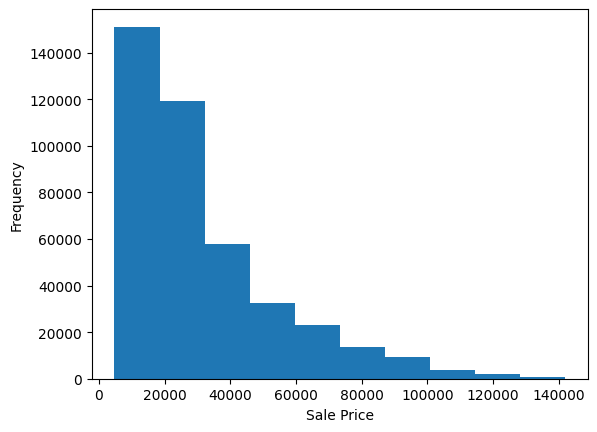

In [11]:
# Check distribution of 'SalePrice'
df['SalePrice'].plot.hist()

plt.xlabel("Sale Price")
plt.show()

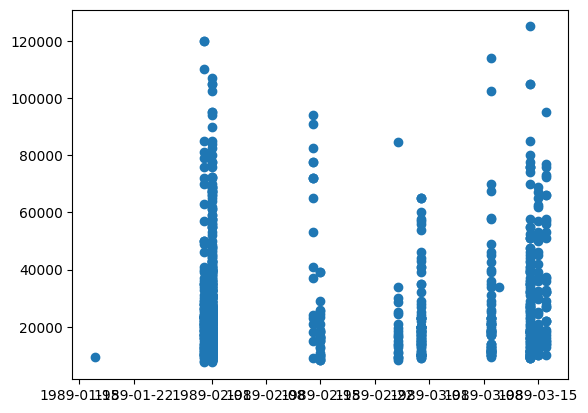

In [12]:
# Scatterplot for 'saledate' against 'SalePrice' (first 1000 records, else too messy)
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000])

##### EDA - Feature Engineering

In [13]:
# Add datetime parameters for 'saledate'
df['saleYear'] = df['saledate'].dt.year
df['saleMonth'] = df['saledate'].dt.month
df['saleDay'] = df['saledate'].dt.day
df['saleDayofWeek'] = df['saledate'].dt.dayofweek

# Since we already have other datetime parameters, 'saledate' is no longer useful and can be dropped
df = df.drop('saledate', axis=1)

df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofWeek
205615,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,2,4592,1743,30,103,63,3,46,43,4,4,3,5,0,1,0,1,2,0,0,2,2,0,0,0,1,0,0,16,2,0,0,2,1,18,28,2,1,0,0,7,5,3,1,1989,1,17,1
274835,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,2,1819,558,30,103,63,3,59,8,5,5,3,5,0,1,1,1,7,0,0,2,2,0,0,0,1,0,0,16,2,0,0,2,1,18,28,2,1,0,0,5,5,3,1,1989,1,31,1
141296,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,2,2347,712,58,103,63,1,49,8,4,4,3,5,0,1,0,1,7,0,0,2,2,0,0,0,1,0,0,16,2,0,0,2,1,18,28,2,1,0,0,7,5,3,1,1989,1,31,1
212552,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,2,1818,557,30,103,63,3,73,8,5,5,3,0,0,1,1,1,7,0,0,2,2,0,0,0,1,0,0,16,2,0,0,2,1,18,28,2,1,0,0,5,5,3,1,1989,1,31,1
62755,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,2,2118,682,20,103,63,3,50,8,4,4,3,5,0,1,0,1,7,0,0,2,2,0,0,0,1,0,0,16,2,0,0,2,1,18,28,2,1,0,0,5,4,3,1,1989,1,31,1


---
### Modelling
Based on: https://scikit-learn.org/stable/machine_learning_map.html, the following machine learning model will be evaluated:
**Random Forest Regressor**

**Take note that since the current df is already split into training+validation, theres no need for further splitting**


##### Split data into training and validation sets
- **Training:** data till end of 2011
- **Validation:** data from 2012 onwards

(https://www.kaggle.com/competitions/bluebook-for-bulldozers/overview)

In [14]:
# Training Set
df_train = df[df['saleYear']<2012]

# Validation Set
df_valid = df[df['saleYear']>=2012]

# Check
len(df_train), len(df_valid)

(401125, 11573)

In [15]:
# Split data into X and y
X_train = df_train.drop("SalePrice", axis=1)
X_valid = df_valid.drop("SalePrice", axis=1)
y_train = df_train['SalePrice']
y_valid = df_valid['SalePrice']

# Check
len(X_train), len(X_valid), len(y_train), len(y_valid)

(401125, 11573, 401125, 11573)

##### Modelling - Building Evaluation Functions

In [16]:
# Since sklearn only has MSLE, hence have to squareroot ourselves
def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error (RMSLE) between predictions and true labels
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Validation MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Validation RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Validation R^2": r2_score(y_valid, val_preds)}
    return scores

##### Modelling - Training model on a subset (since takes too long to train the entire data)

In [17]:
np.random.seed(42)

# Set up instance
model = RandomForestRegressor(n_jobs=-1, # use all available CPU cores
                              max_samples=10000) # train on 10,000 data instead of the entire data

# Fit the model
model.fit(X_train, y_train)

# Determine score of model
show_scores(model)

{'Training MAE': 6030.639131692116,
 'Validation MAE': 8009.722002073791,
 'Training RMSLE': np.float64(0.27828173437655573),
 'Validation RMSLE': np.float64(0.33590014156274717),
 'Training R^2': 0.8359633183204959,
 'Validation R^2': 0.7932199057888494}

---
### Hyperparameter Tuning using `RandomizedSearchCV`
Parameters to tune are decided based on:
- **Random Forest Regressor:** https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [18]:
# Create a hyperparameter grid 
rf_grid = {"n_estimators": np.arange(10,100,10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2,20,2),
           "min_samples_leaf": np.arange(1,20,2),
           "max_features": [0.5, 1, 'sqrt'],
           "max_samples": [10000]
           }

# Setup random hyperparameter search
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=1),
                              param_distributions=rf_grid,
                              n_iter=5,
                              cv=5,
                              verbose=True)

# Fit random hyperparameter search  
rs_model.fit(X_train, y_train)  

# Best params
rs_model.best_params_

# Evaluate test score after tuning
show_scores(rs_model)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'Training MAE': 6357.005441716546,
 'Validation MAE': 8027.238450207452,
 'Training RMSLE': np.float64(0.28678524532667315),
 'Validation RMSLE': np.float64(0.32609417389884376),
 'Training R^2': 0.8200241422747572,
 'Validation R^2': 0.7887620720173654}

##### Train a Model with the Best Hyperparameters

In [19]:
# Most ideal hyperparameters
ideal_model = RandomForestRegressor(**rs_model.best_params_,
                                    n_jobs=-1)

# Fit model
ideal_model.fit(X_train, y_train)

# Evaluate test score 
show_scores(ideal_model)

{'Training MAE': 6372.127457244006,
 'Validation MAE': 7994.299789309846,
 'Training RMSLE': np.float64(0.28786383591671744),
 'Validation RMSLE': np.float64(0.3272138443662189),
 'Training R^2': 0.8196875128612755,
 'Validation R^2': 0.791551264889889}

##### Import Test Data

In [20]:
df_test = pd.read_csv('data/Test.csv',
                      parse_dates=['saledate'])

df_test

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,580,G,NaN,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,Wyoming,BL,Backhoe Loaders,Two Wheel Drive,OROPS,Yes,None or Unspecified,No,Standard,Standard,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,936,NaN,NaN,NaN,Medium,Wheel Loader - 135.0 to 150.0 Horsepower,Virginia,WL,Wheel Loader,NaN,EROPS,Yes,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,20.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,EC210,B,NaN,LC,Large / Medium,"Hydraulic Excavator, Track - 21.0 to 24.0 Metr...",New Jersey,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,330,C,NaN,L,Large / Medium,"Hydraulic Excavator, Track - 33.0 to 40.0 Metr...",New Jersey,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,650,K,NaN,NaN,NaN,"Track Type Tractor, Dozer - 20.0 to 75.0 Horse...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Hydrostatic,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,6643171,2558317,21450,149,2,2008,NaN,NaN,2012-10-24,80NX3,80,NX,3,NaN,Small,"Hydraulic Excavator, Track - 8.0 to 11.0 Metri...",Florida,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Rubber,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
12453,6643173,2558332,21434,149,2,2005,NaN,NaN,2012-10-24,28N,28,N,NaN,NaN,Mini,"Hydraulic Excavator, Track - 2.0 to 3.0 Metric...",Florida,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
12454,6643184,2558342,21437,149,2,1000,NaN,NaN,2012-10-24,35N,35,N,NaN,NaN,Mini,"Hydraulic Excavator, Track - 3.0 to 4.0 Metric...",Florida,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
12455,6643186,2558343,21437,149,2,2006,NaN,NaN,2012-10-24,35N,35,N,NaN,NaN,Mini,"Hydraulic Excavator, Track - 3.0 to 4.0 Metric...",Florida,TEX,Track Excavators,N

##### Preprocess Test Data

In [21]:
# Function to preprocess data
def preprocess_data(df, target_col=None):
    """
    Performs transformations on df and returns transformed df
    """
    # Add datetime parameters for 'saledate'
    df['saleYear'] = df['saledate'].dt.year
    df['saleMonth'] = df['saledate'].dt.month
    df['saleDay'] = df['saledate'].dt.day
    df['saleDayofWeek'] = df['saledate'].dt.dayofweek

    # Since we already have other datetime parameters, 'saledate' is no longer useful and can be dropped
    df = df.drop('saledate', axis=1)

    # Find all columns containing numeric values
    numeric_cols = df.select_dtypes(include='number').columns
    if target_col: # Since the test data does not contain 'SalePrice"
        numeric_cols = numeric_cols.drop(target_col)

    # Loop through each numeric column
    for col in numeric_cols:
        # Impute missing values with median of that column
        df[col] = df[col].fillna(df[col].median())

    # Find all columns containing strings
    obj_cols = df.select_dtypes(include='object').columns
    df[obj_cols] = df[obj_cols].astype('category')

    # Find all columns containing categorical values
    categorical_cols = df.select_dtypes(include='category').columns

    # Loop through each categorical column
    for col in categorical_cols:        
        # Impute missing values with mode (most frequent category)
        df[col] = df[col].fillna(df[col].mode()[0])
        
        # Convert categories to numeric codes
        df[col] = df[col].cat.codes  
        
    return df

In [22]:
# Process the test data
df_test = preprocess_data(df_test)
df_test

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofWeek
0,1227829,1006309,3168,121,3,1999,3688.0,1,498,179,24,48,31,3,1,50,0,0,3,2,1,1,0,1,6,0,0,2,2,0,0,0,1,0,0,12,2,0,0,2,1,16,19,2,0,0,0,3,4,2,1,2012,5,3,3
1,1227844,1022817,7271,121,3,1000,28555.0,0,830,291,24,48,31,3,56,45,5,5,3,0,1,1,1,1,6,0,0,2,2,0,0,0,1,0,0,6,2,0,0,2,1,16,19,2,0,0,0,3,4,2,1,2012,5,10,3
2,1227847,1031560,22805,121,3,2004,6038.0,2,1176,403,8,48,32,2,13,28,3,3,3,1,0,1,0,1,6,0,0,2,2,0,3,0,1,0,0,12,2,0,0,2,1,16,16,1,0,0,0,3,4,2,1,2012,5,10,3
3,1227848,56204,1269,121,3,2006,8940.0,0,286,112,12,48,31,2,17,28,3,3,3,1,0,1,0,1,6,0,0,2,2,0,10,0,1,0,0,12,2,0,0,2,1,16,19,1,1,1,0,3,4,2,1,2012,5,10,3
4,1227863,1053887,22312,121,3,2005,2286.0,1,565,195,32,48,31,3,47,7,4,4,3,2,0,1,0,1,2,0,0,2,2,0,0,0,1,0,0,12,2,0,0,2,1,16,19,2,0,0,0,3,4,2,1,2012,5,10,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,6643171,2558317,21450,149,2,2008,3525.0,2,712,234,43,36,31,5,25,7,3,3,3,1,0,1,0,1,6,0,0,2,2,0,3,0,1,0,0,12,2,0,0,2,0,16,19,2,0,0,0,3,4,2,1,2012,10,24,2
12453,6643173,2558332,21434,149,2,2005,3525.0,2,185,79,42,48,31,4,12,7,3,3,3,0,0,1,0,1,6,0,0,2,2,0,10,0,1,0,0,12,2,0,0,2,1,16,19,2,0,0,0,3,4,2,1,2012,10,24,2
12454,6643184,2558342,21437,149,2,1000,3525.0,2,324,122,42,48,31,4,16,7,3,3,3,0,0,1,0,1,6,0,0,2,2,0,10,0,1,0,0,12,2,0,0,2,1,16,19,2,0,0,0,3,4,2,1,2012,10,24,2
12455,6643186,2558343,21437,149,2,2006,3525.0,2,324,122,42,48,31,4,16,7,3,3,3,0,0,1,0,1,6,0,0,2,2,0,10,0,1,0,0,12,2,0,0,2,1,16,19,2,0,0,0,3,4,2,1,2012,10,24,2


##### Make Predictions on Test Data

In [25]:
# Make predictions on test data
test_preds = ideal_model.predict(df_test)

# Format predictions based on Competition's standard
df_preds = pd.DataFrame()
df_preds['SalesID'] = df_test['SalesID']
df_preds['SalesPrice'] = test_preds

# View Results
df_preds

,SalesID,SalesPrice
0,1227829,22241.273408
1,1227844,21093.682073
2,1227847,54886.882794
3,1227848,58428.606377
4,1227863,60637.680145
...,...,...
12452,6643171,34153.531735
12453,6643173,17154.897594
12454,6643184,17585.555717
12455,6643186,20130.514228
